# experimental notebook for fixing some of the depth fit issues

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
os.environ["GDAL_DATA"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/gdal"
os.environ["PROJ_LIB"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/proj"
os.environ["PROJ_DATA"] = "/Users/parndt/anaconda3/envs/eeicelakes-env/share/proj"
import ee
import h5py
import math
import datetime
import requests
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import timezone
from datetime import timedelta
from datetime import datetime 
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp
import matplotlib
import matplotlib.pylab as plt
import matplotlib.transforms as mtrans
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5

## the functions for imagery retrieval

In [2]:
viz_bands = ['B4', 'B3', 'B2']
viz_bands_rename = ['R', 'G', 'B']
min_sun_elevation = 20

#####################################################################
def get_cloudfree_image_collection(area_of_interest, date_time, days_buffer, max_cloud_scene=50, max_cloud_mask=20):
    
    datetime_requested = datetime.strptime(date_time, '%Y-%m-%dT%H:%M:%SZ')
    start_date = (datetime_requested - timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%SZ')
    end_date = (datetime_requested + timedelta(days=days_buffer)).strftime('%Y-%m-%dT%H:%M:%SZ')
    # print('Looking for images from %s to %s' % (start_date, end_date), end=' ')
    
    def get_sentinel2_collection(area_of_interest, start_date, end_date):
        sentinel2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                                .filterBounds(area_of_interest)
                                .filterDate(start_date, end_date)
                                .filterMetadata('MEAN_SOLAR_ZENITH_ANGLE', 'less_than', ee.Number(90).subtract(min_sun_elevation)))
    
        s2cloudless_collection = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
                                  .filterBounds(area_of_interest)
                                  .filterDate(start_date, end_date))
    
        return (ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
            'primary': sentinel2_collection,
            'secondary': s2cloudless_collection,
            'condition': ee.Filter.equals(**{
                'leftField': 'system:index',
                'rightField': 'system:index'
            })
        })))
    
    def add_cloud_bands_S2(image):
        cloud = ee.Image(image.get('s2cloudless')).select('probability').rename('cloudScore')
        scene_id = image.get('PRODUCT_ID')
        return image.addBands(cloud).set('scene_id', scene_id)
    
    def mask_S2(img):
        mask = img.select('cloudScore').lt(max_cloud_mask)
        return img.updateMask(mask)
    
    def normalize_brightness_S2(image):
        return image.addBands(image.select(viz_bands).rename(viz_bands_rename))
    
    def get_landsat_collection(area_of_interest, start_date, end_date):
        L8T1 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
        L8T2 = ee.ImageCollection('LANDSAT/LC08/C02/T2_TOA')
        L9T1 = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA')
        L9T2 = ee.ImageCollection('LANDSAT/LC09/C02/T2_TOA')
        return (L8T1.merge(L8T2).merge(L9T2).merge(L9T2)
                .filterBounds(area_of_interest)
                .filterDate(start_date, end_date)
                   .filterMetadata('SUN_ELEVATION', 'greater_than', min_sun_elevation))
    
    def landsat_cloud_score(image):
        cloud = ee.Algorithms.Landsat.simpleCloudScore(image).select('cloud').rename('cloudScore')
        scene_id = image.get('LANDSAT_PRODUCT_ID')
        return image.addBands(cloud).set('scene_id', scene_id)
    
    def mask_landsat(img):
        mask = img.select('cloudScore').lt(max_cloud_mask)
        return img.updateMask(mask)
    
    def normalize_brightness_LST(image):
        return image.addBands(image.select(viz_bands).rename(viz_bands_rename))
    
    def get_sentinel2_cloud_collection(area_of_interest, start_date, end_date, max_cloud_scene=50, max_cloud_mask=20):
        
        def set_cloudiness(img, aoi=area_of_interest):
            cloudprob = img.select(['cloudScore']).reduceRegion(reducer=ee.Reducer.mean(), 
                                                                 geometry=aoi, 
                                                                 bestEffort=True, 
                                                                 maxPixels=1e6)
            return img.set('ground_track_cloud_prob', cloudprob.get('cloudScore'))
        
        return (get_sentinel2_collection(area_of_interest, start_date, end_date)
                         .map(add_cloud_bands_S2)
                         .map(set_cloudiness)
                         # .filter(ee.Filter.lt('ground_track_cloud_prob', max_cloud_scene))
                         .map(mask_S2)
                         .map(normalize_brightness_S2)
               )
    
    def get_landsat_cloud_collection(area_of_interest, start_date, end_date, max_cloud_scene=50, max_cloud_mask=20):
        
        def set_cloudiness(img, aoi=area_of_interest):
            cloudprob = img.select(['cloudScore']).reduceRegion(reducer=ee.Reducer.mean(), 
                                                                 geometry=aoi, 
                                                                 bestEffort=True, 
                                                                 maxPixels=1e6)
            return img.set('ground_track_cloud_prob', cloudprob.get('cloudScore'))
        
        return (get_landsat_collection(area_of_interest, start_date, end_date)
                         .map(landsat_cloud_score)
                         .map(set_cloudiness)
                         # .filter(ee.Filter.lt('ground_track_cloud_prob', max_cloud_scene))
                         .map(mask_landsat)
                         .map(normalize_brightness_LST)
               )
    
    # def clipToROI(img):
    #     return img.clip(area_of_interest)

    S2_collection = get_sentinel2_cloud_collection(area_of_interest, start_date, end_date, max_cloud_scene, max_cloud_mask)
    LST_collection = get_landsat_cloud_collection(area_of_interest, start_date, end_date, max_cloud_scene, max_cloud_mask)

    return S2_collection.merge(LST_collection)

#####################################################################
def download_imagery(fn, lk, gt, imagery_filename, days_buffer=3, max_cloud_scene=50, max_cloud_mask=20, gamma_value=1.8, 
                     buffer_factor=1.2, crs_out='EPSG:3031', n_imgs_mosaic=7, scale_out=10, mosaic_method='mosaic'):

    lake_mean_delta_time = lk.mframe_data.dt.mean()
    ATLAS_SDP_epoch_datetime = datetime(2018, 1, 1, tzinfo=timezone.utc) # 2018-01-01:T00.00.00.000000 UTC, from ATL03 data dictionary 
    ATLAS_SDP_epoch_timestamp = datetime.timestamp(ATLAS_SDP_epoch_datetime)
    lake_mean_timestamp = ATLAS_SDP_epoch_timestamp + lake_mean_delta_time
    lake_mean_datetime = datetime.fromtimestamp(lake_mean_timestamp, tz=timezone.utc)
    time_format_out = '%Y-%m-%dT%H:%M:%SZ'
    is2time = datetime.strftime(lake_mean_datetime, time_format_out)

    # get the bounding box
    lon_rng = gt.lon.max() - gt.lon.min()
    lat_rng = gt.lat.max() - gt.lat.min()
    fac = 0.25
    bbox = [gt.lon.min()-fac*lon_rng, gt.lat.min()-fac*lat_rng, gt.lon.max()+fac*lon_rng, gt.lat.max()+fac*lat_rng]
    poly = [(bbox[x[0]], bbox[x[1]]) for x in [(0,1), (2,1), (2,3), (0,3), (0,1)]]
    roi = ee.Geometry.Polygon(poly)

    # get the earth engine collection
    collection_size = 0
    if days_buffer > 200:
        days_buffer = 200
    increment_days = days_buffer
    while (collection_size<n_imgs_mosaic) & (days_buffer <= 200):

        cloudfree_collection = get_cloudfree_image_collection(area_of_interest=roi, 
                                                    date_time=is2time, 
                                                    days_buffer=days_buffer, 
                                                    max_cloud_scene=max_cloud_scene, 
                                                    max_cloud_mask=max_cloud_mask)

        cloudfree_collection = cloudfree_collection.filter(ee.Filter.lt('ground_track_cloud_prob', max_cloud_scene))
        collection_size = cloudfree_collection.size().getInfo()
        days_buffer += increment_days
    
    # get the time difference between ICESat-2 and Sentinel-2 and sort by it 
    # is2time = lk.date_time
                         
    def set_time_difference(img, is2time=lake_mean_timestamp):
        timediff = ee.Date(lake_mean_timestamp*1000).difference(img.get('system:time_start'), 'second').abs()
        return img.set('timediff', timediff)
    cloudfree_collection = cloudfree_collection.map(set_time_difference).sort('timediff')

    # create a region around the ground track over which to download data
    lon_center = gt.lon.mean()
    lat_center = gt.lat.mean()
    gt_length = gt.x10.max() - gt.x10.min()
    point_of_interest = ee.Geometry.Point(lon_center, lat_center)
    region_of_interest = point_of_interest.buffer(np.nanmax((gt_length*0.5*buffer_factor,500)))

    prod_id = 'no imagery'
    if collection_size > 0:
        
        # stretch the color values 
        def color_stretch(image):
            percentiles = image.select(viz_bands_rename).reduceRegion(**{
                'reducer': ee.Reducer.percentile(**{'percentiles': [3, 97], 'outputNames': ['lower', 'upper']}),
                'geometry': region_of_interest,
                'scale': 30,
                'maxPixels': 1e9,
                'bestEffort': True
            })
            lower = percentiles.select(['.*_lower']).values().reduce(ee.Reducer.min())
            upper = percentiles.select(['.*_upper']).values().reduce(ee.Reducer.max())
            return image.select(viz_bands_rename).unitScale(lower, upper).clamp(0,1).resample('bilinear').reproject(**{'crs': crs_out,'scale': scale_out})
        
        # limit mosaic to first n images after sorting by timediff
        selectedImage = cloudfree_collection.first()
        # to_mosaic = cloudfree_collection.limit(n_imgs_mosaic,'timediff',True).map(color_stretch)
        to_mosaic = cloudfree_collection.limit(n_imgs_mosaic).map(color_stretch)
        # select the first image for info
        
        if mosaic_method == 'mean':
            rgb = to_mosaic.mean()
        elif mosaic_method == 'median':
            rgb = to_mosaic.median()
        else:
            # mosaic() puts last image in collection on top, so sort by timediff in descending order (the False value)
            # to_mosaic = to_mosaic.sort('timediff', True)
            print('mosaic with closest image on top')
            # info = to_mosaic.getInfo()
            # for f in info['features']:
            #     print(f['properties']['timediff'], f['properties']['scene_id'])
            to_mosaic = to_mosaic.sort('timediff', False)
            rgb = to_mosaic.mosaic()
            
        rgb_gamma = rgb.pow(1/gamma_value)
        rgb8bit = rgb_gamma.clamp(0,1).multiply(255).uint8()
        
        # from the selected image get some stats: product id, cloud probability and time difference from icesat-2
        prod_id = selectedImage.get('scene_id').getInfo()
        cld_prb = selectedImage.get('ground_track_cloud_prob').getInfo()
        s2_timestamp = selectedImage.get('system:time_start').getInfo()
        s2datetime = datetime.fromtimestamp(s2_timestamp/1000, tz=timezone.utc)
        s2datestr = datetime.strftime(s2datetime, 'time_format_out')
        is2datetime = lake_mean_datetime
        timediff = s2datetime - is2datetime
        timediff_str = '%s' % (timediff)
        
        # get the download URL and download the selected image
        success = False
        tries = 0
        while (success == False) & (tries <= 10):
            try:
                downloadURL = rgb8bit.getDownloadUrl({'name': 'mySatelliteImage',
                                                          'crs': crs_out,
                                                          'scale': scale_out,
                                                          'region': region_of_interest,
                                                          'filePerBand': False,
                                                          'format': 'GEO_TIFF'})
        
                response = requests.get(downloadURL)
                with open(imagery_filename, 'wb') as f:
                    f.write(response.content)
        
                # print('--> Downloaded the 8-bit RGB image as %s.' % imagery_filename)
                success = True
                tries += 1
            except:
                traceback.print_exc()
                scale_out *= 2
                # print('-> download unsuccessful, increasing scale to %.1f...' % scale)
                success = False
                tries += 1

    return prod_id, timediff_str
            
#####################################################################
def plot_imagery(fn, days_buffer=5, max_cloud_scene=50, max_cloud_mask=20, xlm=[None, None], ylm=[None, None], gamma_value=1.8, imagery_filename=None,
                 re_download=True, ax=None, buffer_factor=1.5, crs_out='EPSG:3031', n_imgs_mosaic=7, scale_out=10, mosaic_method='mosaic'):
                     
    lk = dictobj(read_melt_lake_h5(fn))
    time_format_out = '%Y-%m-%dT%H:%M:%SZ'
    lake_mean_delta_time = lk.mframe_data.dt.mean()
    ATLAS_SDP_epoch_datetime = datetime(2018, 1, 1, tzinfo=timezone.utc) # 2018-01-01:T00.00.00.000000 UTC, from ATL03 data dictionary 
    ATLAS_SDP_epoch_timestamp = datetime.timestamp(ATLAS_SDP_epoch_datetime)
    lake_mean_timestamp = ATLAS_SDP_epoch_timestamp + lake_mean_delta_time
    lake_mean_datetime = datetime.fromtimestamp(lake_mean_timestamp, tz=timezone.utc)
    lake_mean_time_string = datetime.strftime(lake_mean_datetime, time_format_out)
    lk.date_time = lake_mean_time_string
                     
    df = lk.photon_data.copy()
    if not xlm[0]:
        xlm[0] = df.xatc.min()
    if not xlm[1]:
        xlm[1] = df.xatc.max()
    if not ylm[0]:
        ylm[0] = lk.surface_elevation-2*lk.max_depth
    if not ylm[1]:
        ylm[1] = lk.surface_elevation+lk.max_depth
    if not imagery_filename:
        imagery_filename = 'imagery' + fn[fn.rfind('/'):].replace('.h5','.tif')
    
    
    df = df[(df.xatc >= xlm[0]) & (df.xatc <= xlm[1]) & (df.h >= ylm[0]) & (df.h <= ylm[1])].reset_index(drop=True).copy()
    x_off = np.min(df.xatc)
    df.xatc -= x_off
    
    dfd = lk.depth_data.copy()
    dfd.xatc -= x_off

    # get the ground track
    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby(by='x10')[['lat', 'lon']].median().reset_index()
    lon_center = gt.lon.mean()
    lat_center = gt.lat.mean()
                     
    try:
        prod_id = 'no imagery'
        if ((not os.path.isfile(imagery_filename)) or re_download) and ('modis' not in imagery_filename):
            prod_id, dt_str = download_imagery(fn=fn, lk=lk, gt=gt, imagery_filename=imagery_filename, days_buffer=days_buffer, 
                             max_cloud_scene=max_cloud_scene, max_cloud_mask=max_cloud_mask, gamma_value=gamma_value, 
                             buffer_factor=buffer_factor, crs_out=crs_out, n_imgs_mosaic=n_imgs_mosaic, scale_out=scale_out,
                             mosaic_method=mosaic_method)
        
        try:
            myImage = rio.open(imagery_filename)
            
            # make the figure
            if not ax:
                fig, ax = plt.subplots(figsize=[6,6])
            
            rioplot.show(myImage, ax=ax)
            ax.axis('off')
        except:
            traceback.print_exc()
    
        try:
            dt_str = dt_str.split('.')[0]
            if dt_str[0] != '-':
                dt_str = '+' + dt_str
            text = 'closest image time difference: %s\n%s' % (dt_str, prod_id)
            ax.text(0.01, 0.01, text, fontsize=6, ha='left', va='bottom', transform=ax.transAxes,
               bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.1,rounding_size=0.3', lw=0), zorder=3000)
        except:
            traceback.print_exc()
    
        try:
            ximg, yimg = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=np.array(gt.lon), ys=np.array(gt.lat))
            if 'modis' in imagery_filename:
                xrng = ximg[-1] - ximg[0]
                yrng = yimg[-1] - yimg[0]
                fac = 30
                # print('using saved modis image')
                ax.plot([ximg[-1]+fac*xrng,ximg[0]-fac*xrng], [yimg[-1]+fac*yrng, yimg[0]-fac*yrng], 'k:', lw=1)
                ax.annotate('', xy=(ximg[-1]+fac*xrng, yimg[-1]+fac*yrng), xytext=(ximg[0]-fac*xrng, yimg[0]-fac*yrng),
                                 arrowprops=dict(width=0, lw=0, headwidth=5, headlength=5, color='k'),zorder=1000)
                # ax.plot(ximg, yimg, 'r-', lw=1, zorder=5000)
            else:
                # print('plotting ground track')
                ax.annotate('', xy=(ximg[-1], yimg[-1]), xytext=(ximg[0], yimg[0]),
                                 arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='k'),zorder=1000)
                try:
                    isdepth = dfd.depth>0
                    bed = dfd.h_fit_bed
                    bed[~isdepth] = np.nan
                    # bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
                    surf = np.ones_like(dfd.xatc) * lk.surface_elevation
                    surf[~isdepth] = np.nan
                    xatc_surf = np.array(dfd.xatc)[~np.isnan(surf)]
                    lon_bed = np.array(dfd.lon)
                    lat_bed = np.array(dfd.lat)
                    lon_bed[(np.isnan(surf)) & (np.isnan(bed))] = np.nan
                    lat_bed[(np.isnan(surf)) & (np.isnan(bed))] = np.nan
                    xb, yb = warp.transform(src_crs='epsg:4326', dst_crs=myImage.crs, xs=lon_bed, ys=lat_bed)
                    ax.plot(xb, yb, 'r-', lw=1, zorder=5000)
                except:
                    traceback.print_exc()
        except:
            traceback.print_exc()
            
        if not ax:
            fig.tight_layout(pad=0)
    
        return myImage, lon_center, lat_center
    except: 
        return None, lon_center, lat_center
        traceback.print_exc()

                     
#####################################################################
def plotIS2(fn, ax=None, xlm=[None, None], ylm=[None,None], cmap=cmc.lapaz_r, name='ICESat-2 data'):
    lk = dictobj(read_melt_lake_h5(fn))
    time_format_out = '%Y-%m-%dT%H:%M:%SZ'
    lake_mean_delta_time = lk.mframe_data.dt.mean()
    ATLAS_SDP_epoch_datetime = datetime(2018, 1, 1, tzinfo=timezone.utc) # 2018-01-01:T00.00.00.000000 UTC, from ATL03 data dictionary 
    ATLAS_SDP_epoch_timestamp = datetime.timestamp(ATLAS_SDP_epoch_datetime)
    lake_mean_timestamp = ATLAS_SDP_epoch_timestamp + lake_mean_delta_time
    lake_mean_datetime = datetime.fromtimestamp(lake_mean_timestamp, tz=timezone.utc)
    lake_mean_time_string = datetime.strftime(lake_mean_datetime, time_format_out)
    lk.date_time = lake_mean_time_string
    df = lk.photon_data.copy()
    dfd = lk.depth_data.copy()

    try:
        isdepth = dfd.depth>0
        bed = dfd.h_fit_bed
        bed[~isdepth] = np.nan
        bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
        surf = np.ones_like(dfd.xatc) * lk.surface_elevation
        surf[~isdepth] = np.nan
        surf_only = surf[~np.isnan(surf)]
        bed_only = bed[(~np.isnan(surf)) & (~np.isnan(bed))]
        xatc_surf = np.array(dfd.xatc)[~np.isnan(surf)]
        xatc_bed = np.array(dfd.xatc)[(~np.isnan(surf)) & (~np.isnan(bed))]
        
        # make the figure
        if not ax:
            fig, ax = plt.subplots(figsize=[8,5])
    
        df['is_afterpulse']= df.prob_afterpulse > np.random.uniform(0,1,len(df))
        if not cmap:
            # ax.scatter(df.xatc, df.h, s=1, c='k')
            ax.scatter(df.xatc[~df.is_afterpulse], df.h[~df.is_afterpulse], s=1, c='k')
        else:
            ax.scatter(df.xatc[~df.is_afterpulse], df.h[~df.is_afterpulse], s=1, c=df.snr, cmap=cmap)
        
        # ax.scatter(dfd.xatc[isdepth], dfd.h_fit_bed[isdepth], s=4, color='r', alpha=dfd.conf[isdepth])
        ax.scatter(dfd.xatc[isdepth], dfd.h_fit_bed[isdepth], s=dfd.conf[isdepth]*15, c=[(1, 1-x, 1-x) for x in dfd.conf[isdepth]], 
                   edgecolors='none', alpha=dfd.conf[isdepth])
        ax.plot(dfd.xatc, dfd.h_fit_bed, color='gray', lw=1)
        ax.plot(dfd.xatc, dfd.h_fit_surf, color='gray', lw=0.5)
        
        # ax.plot(dfd.xatc, bed, color='r', lw=1)
        ax.plot(dfd.xatc, surf, color='C0', lw=1)
    except:
        traceback.print_exc()
        try:
            ax.scatter(df.xatc, df.h, s=1, c='k')
            ax.plot(dfd.xatc, dfd.h_fit_bed, 'r-')
            ax.plot(dfd.xatc, np.ones_like(dfd.xatc) * lk.surface_elevation, 'b-')
        except:
            traceback.print_exc()

    # add the length of surface
    try:
        arr_y = lk.surface_elevation+lk.max_depth*0.25
        elev_y = lk.surface_elevation+lk.max_depth*0.05
        x_start = np.min(xatc_surf)
        x_end = np.max(xatc_surf)
        x_mid = (x_end + x_start) / 2
        len_surf_m = np.floor((x_end-x_start)/100)*100
        len_surf_km = len_surf_m/1000
        arr_x1 = x_mid - len_surf_m / 2
        arr_x2 = x_mid + len_surf_m / 2
        ax.annotate('', xy=(arr_x1, arr_y), xytext=(arr_x2, arr_y),
                             arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0'),zorder=1000)
        ax.annotate('', xy=(arr_x2, arr_y), xytext=(arr_x1, arr_y),
                             arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='C0'),zorder=1000)
        ax.text(x_mid, arr_y, '%.1f km' % len_surf_km, fontsize=12, ha='center', va='bottom', color='C0', fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))
        ax.text(x_mid, elev_y, '%.0f m' % lk.surface_elevation, va='bottom', ha='center', color='C0', 
                fontsize=10, bbox=dict(facecolor='white', alpha=0.65, boxstyle='round,pad=0.1,rounding_size=0.5', lw=0))
    except:
        traceback.print_exc()

    # add the max depth
    try:
        if np.sum(np.isnan(bed)) < len(bed):
            y_low = np.nanmin(bed)
            if y_low < (lk.surface_elevation - 2 * lk.max_depth):
                bed[bed < lk.surface_elevation - 2 * lk.max_depth] = np.nan
                if np.sum(np.isnan(bed)) < len(bed):
                    y_low = np.nanmin(bed)
            if np.sum(np.isnan(bed)) < len(bed):
                y_up = lk.surface_elevation
                arr_x = xatc_bed[np.argmin(bed_only)]
                xlm = (df.xatc.min(), df.xatc.max())
                arr_x = xlm[0] - 0.0* (xlm[1] - xlm[0])
                y_len = y_up - y_low
                y_mid = (y_up + y_low) / 2
                arr_len = y_len
                arr_y1 = y_mid + arr_len / 2
                arr_y2 = y_mid - arr_len / 2
                ref_index = 1.336
                dep_round = np.round(y_len / ref_index, 1)
                ax.annotate('', xy=(arr_x, arr_y2), xytext=(arr_x, arr_y1),
                                     arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
                ax.annotate('', xy=(arr_x, arr_y1), xytext=(arr_x, arr_y2),
                                     arrowprops=dict(width=0.7, headwidth=5, headlength=5, color='r'),zorder=1000)
                ax.text(arr_x, y_mid, '%.1f m' % dep_round, fontsize=12, ha='right', va='center', color='r', fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.8, lw=0, boxstyle='round,pad=0.2,rounding_size=0.5'), rotation=90)
    except:
        traceback.print_exc()

    # add the title
    try:
        datestr = datetime.strftime(datetime.strptime(lk.date_time,'%Y-%m-%dT%H:%M:%SZ'), '%d %B %Y %H:%M:%S UTC')
        sheet = lk.ice_sheet
        region = lk.polygon_filename.split('_')[-1].replace('.geojson', '')
        if sheet == 'AIS':
            region = region + ' (%s)' % lk.polygon_filename.split('_')[-2]
        latstr = lk.lat_str[:-1] + '°' + lk.lat_str[-1]
        lonstr = lk.lon_str[:-1] + '°' + lk.lon_str[-1]
        description = '%s, %s - %s (%s, %s, %.1fm)\n%s %s (%s), max depth: %.2f m' % (datestr, sheet, region, latstr, lonstr, 
                       lk.surface_elevation, lk.granule_id, lk.gtx, lk.beam_strength, lk.max_depth)
        
        ax.text(0.5, 1.0, description, fontsize=8, ha='center', va='top', transform=ax.transAxes,
               bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0), zorder=3000)
    except:
        traceback.print_exc()

    # add the lake quality
    try:
        thiscol = 'g' if lk.depth_quality_sort > 1 else 'r'
        ax.text(0.97, 0.03, 'SuRRF quality score: %.2f' % lk.depth_quality_sort, fontsize=12, ha='right', va='bottom', color=thiscol, 
                fontweight='bold', transform=ax.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))
    except:
        traceback.print_exc()

    try:
        xlm = (df.xatc.min(), df.xatc.max())
        dp = lk.max_depth
        if dp < 2.0:
            dp = 2.0
        ylm = (lk.surface_elevation-dp*2, lk.surface_elevation+dp)
        ax.set_xlim(xlm)
        ax.set_ylim(ylm)
    except:
        traceback.print_exc()

    # try:
    #     transmix = mtrans.blended_transform_factory(ax.transAxes, ax.transData)
    #     ax.text(0.99, lk.surface_elevation, '%.1f m' % lk.surface_elevation, transform=transmix, va='center', ha='right', color='C0', 
    #             fontweight='bold', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2,rounding_size=0.5', lw=0))
    # except:
    #     traceback.print_exc()
        
    ax.axis('off')

    
#####################################################################
def plot_IS2_imagery(fn, axes=None, xlm=[None,None], ylm=[None,None], cmap=None, days_buffer=5, max_cloud_scene=50, max_cloud_mask=50,
                     gamma_value=1.8, imagery_filename=None, re_download=True, img_aspect=3/2, name='ICESat-2 data',
                     return_fig=False, n_imgs_mosaic=7, scale_out=10, mosaic_method='mosaic'):

    if not axes:
        fig = plt.figure(figsize=[12,6], dpi=80)
        gs = fig.add_gridspec(1,3)
        axp = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:])]
    else:
        axp = axes
        
    ax = axp[1]
    try:
        plotIS2(fn=fn, ax=ax, xlm=xlm, ylm=ylm, cmap=cmap, name=name)
    except:
        ax.text(0.5, 0.5, 'plotting error', fontsize=12, ha='center', va='center', transform=ax.transAxes)
        traceback.print_exc()
    
    ax = axp[0]
    try:
        with h5py.File(fn) as f:
            icesheet = f['properties']['ice_sheet'][()].decode('utf-8')
        crs_out = 'EPSG:3413' if icesheet=='GrIS' else 'EPSG:3031'
        center_lon, center_lat = 0, 0
        img, center_lon, center_lat = plot_imagery(fn=fn, days_buffer=days_buffer, max_cloud_scene=max_cloud_scene, 
            max_cloud_mask=max_cloud_mask, xlm=xlm, ylm=ylm, gamma_value=gamma_value, imagery_filename=imagery_filename, 
            re_download=re_download, ax=ax, crs_out=crs_out, n_imgs_mosaic=n_imgs_mosaic, scale_out=scale_out,
            mosaic_method=mosaic_method)
        
        if img:        
            if imagery_filename:
                if 'modis' in imagery_filename:
                    center_x, center_y = warp.transform(src_crs='epsg:4326', dst_crs=img.crs, xs=[center_lon], ys=[center_lat])
                    center_x = center_x[0]
                    center_y = center_y[0]
                    rng = 220000
                    if img_aspect > 1:
                        ax.set_xlim(center_x - 0.5*rng/img_aspect, center_x + 0.5*rng/img_aspect)
                        ax.set_ylim(center_y - 0.5*rng, center_y + 0.5*rng)
                    if img_aspect < 1:
                        ax.set_xlim(center_x - 0.5*rng, center_x + 0.5*rng)
                        ax.set_ylim(center_y - 0.5*rng*img_aspect, center_y + 0.5*rng*img_aspect)
                    
            if (img_aspect > 1): 
                h_rng = img.bounds.top - img.bounds.bottom
                cntr = (img.bounds.right + img.bounds.left) / 2
                ax.set_xlim(cntr-0.5*h_rng/img_aspect, cntr+0.5*h_rng/img_aspect)
            elif img_aspect < 1: 
                w_rng = img.bounds.right - img.bounds.left
                cntr = (img.bounds.top + img.bounds.bottom) / 2
                ax.set_ylim(cntr-0.5*w_rng*img_aspect, cntr+0.5*w_rng/img_aspect)
    except:
        ax.text(0.5, 0.5, 'plotting error', fontsize=12, ha='center', va='center', transform=ax.transAxes)
        traceback.print_exc()
            
    
    if not axes:
        fig.tight_layout(pad=1, h_pad=0, w_pad=0)
        if not name:
            name = 'zzz' + lk.polygon_filename.split('_')[-1].replace('.geojson', '')
        outname = 'figplots/' + name.replace(' ', '') + fn[fn.rfind('/')+1:].replace('.h5','.jpg')
        fig.savefig(outname, dpi=300)

    if return_fig:
        plt.close(fig)
        return center_lon, center_lat, fig
    else:
        return center_lon, center_lat

## rename files with more concise names

In [3]:
# folder where the data lives
base_dir = '../GLD3_complete/GrIS/testfolder'
# base_dir = '../GLD3_complete/GrIS'

In [4]:
if base_dir[-1] != '/':
    base_dir += '/'
    
searchdir = base_dir + 'detection_out_data/'
searchfor = '.h5'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist.sort()
listlength = len(filelist)
print('number .h5:', listlength)

searchdir_img = base_dir + 'detection_out_plot/'
searchfor_img = '.jpg'
filelist_img = [searchdir_img+f for f in os.listdir(searchdir_img) \
            if os.path.isfile(os.path.join(searchdir_img, f)) & (searchfor_img in f)]
filelist_img.sort()
listlength_img = len(filelist_img)
print('number .jpg:', listlength_img)

number .h5: 14
number .jpg: 26


In [5]:
# ! cp ../GLD3_complete/GrIS/detection_out_data/lake_097773_GrIS_2019_simplified_GRE_2200_CW_ATL03_20190617064249_12220303_006_02_gt1l_0001.h5 ../GLD3_complete/GrIS/testfolder/detection_out_data/lake_097773_GrIS_2019_simplified_GRE_2200_CW_ATL03_20190617064249_12220303_006_02_gt1l_0001.h5 

In [6]:
def fix_fringe_segment(lk, segment, start=True, plotit=False):

    dfd = lk.depth_data.copy().reset_index(drop=True)

    ref_idx = 1.336
    seg = segment
    xvals = np.arange(seg[0], seg[1])
    xadj = (np.sin((xvals - seg[0]) / (seg[1] - seg[0]) * np.pi - np.pi/2) + 1) / 2
    if not start:
        xadj = 1 - xadj
    surf = dfd.loc[seg[0]:seg[1]-1,'h_fit_surf']
    bed = dfd.loc[seg[0]:seg[1]-1,'h_fit_bed']

    if plotit:
        fig, ax = plt.subplots()
        ax.plot(xvals, surf-lk.surface_elevation)
        ax.plot(xvals, bed-lk.surface_elevation)

    bed_fix = bed * xadj +  surf * (1-xadj)
    dfd.loc[seg[0]:seg[1]-1,'h_fit_bed'] = bed_fix
    dfd.loc[seg[0]:seg[1]-1,'depth'] = bed_fix
    lk.depth_data = dfd

    if plotit:
        ax.plot(xvals, bed_fix-lk.surface_elevation, 'r--')
        ax.plot(xvals, xadj)
        display(fig)


def fix_fringes(lk, h_range=1.0, ref_idx = 1.336, verbose=False):
    
    df = lk.photon_data.copy()
    dfd = lk.depth_data.copy().reset_index(drop=True)
    
    diff_bed = (lk.surface_elevation - dfd.h_fit_bed)/ref_idx
    diff_surf = dfd.h_fit_surf - lk.surface_elevation
    
    smooth_meters = 10
    sat = df.groupby(['mframe', 'ph_id_pulse'])[['xatc', 'sat_ratio']].mean().sort_values(by='xatc').reset_index(drop=True)
    res = np.nanmean(np.diff(sat.xatc))
    wdw = int(np.ceil(smooth_meters/res))
    sat['smooth'] = sat.sat_ratio.rolling(window=10*wdw, win_type='gaussian', min_periods=1, center=True).mean(std=wdw)
    dfd['sat'] = np.interp(dfd.xatc, sat.xatc, sat.smooth)
    
    isfringe = ((diff_surf <= h_range) & (diff_bed <= h_range)) | ((dfd.depth > 1) & (dfd.sat > 2))
    
    hasstarted_top = False
    hasstarted_bot = False
    segments = {'start': [], 'end': []}
    for i in list(isfringe.index):
        if (i == 0) and isfringe.loc[i]:
            hasstarted_top = True
            start = i
        if i>0:
            if (not hasstarted_top) and isfringe.loc[i] and (not isfringe.loc[i-1]) & (diff_surf.loc[i-1] > h_range):
                hasstarted_top = True
                start = i 
                if verbose:
                    print('start top', i)
            elif (not hasstarted_bot) and isfringe.loc[i] and (not isfringe.loc[i-1]) & (diff_bed.loc[i-1] > h_range):
                hasstarted_bot = True
                start = i 
                if verbose:
                    print('start bot', i)
            elif hasstarted_top and isfringe.loc[i-1] and ((not isfringe.loc[i]) or (i==list(isfringe.index)[-1])):
                hasstarted_top = False
                if (diff_bed.loc[i] > h_range):
                    end = i 
                    segments['start'].append((start, end))
                    if verbose:
                        print('end bot', i)
                        print('---> start %i to end %i' % (start, end))
                else:
                    if verbose:
                        print('end top', i)
            elif hasstarted_bot and isfringe.loc[i-1] and ((not isfringe.loc[i]) or (i==list(isfringe.index)[-1])):
                hasstarted_bot = False
                if (diff_surf.loc[i] > h_range) or (i==list(isfringe.index)[-1]):
                    end = i
                    segments['end'].append((start, end))
                    if verbose:
                        print('end top', i)
                        print('---> start %i to end %i' % (start, end))
                else:
                    if verbose:
                        print('end bot', i)

    for seg in segments['start']:
        fix_fringe_segment(lk, seg, start=True)
    for seg in segments['end']:
        fix_fringe_segment(lk, seg, start=False)  

0
start top 30
end bot 45
---> start 30 to end 45
start bot 357
end top 371
---> start 357 to end 371
1
start top 16
end bot 68
---> start 16 to end 68
start bot 341
end top 383
---> start 341 to end 383
2
start top 33
end bot 40
---> start 33 to end 40
start bot 111
end top 114
---> start 111 to end 114
3
start top 29
end bot 56
---> start 29 to end 56
start bot 96
end top 115
---> start 96 to end 115
4
start top 25
end bot 47
---> start 25 to end 47
start bot 324
end bot 345
start bot 356
end top 385
---> start 356 to end 385
5
start top 35
end bot 51
---> start 35 to end 51
start bot 159
end top 168
---> start 159 to end 168
6
start top 34
end bot 42
---> start 34 to end 42
start bot 294
end top 298
---> start 294 to end 298
7
start top 19
end top 29
start top 37
end bot 40
---> start 37 to end 40
start bot 65
end top 67
---> start 65 to end 67
8
start top 30
end bot 46
---> start 30 to end 46
start bot 226
end top 243
---> start 226 to end 243
9
start top 28
end top 29
start top 30

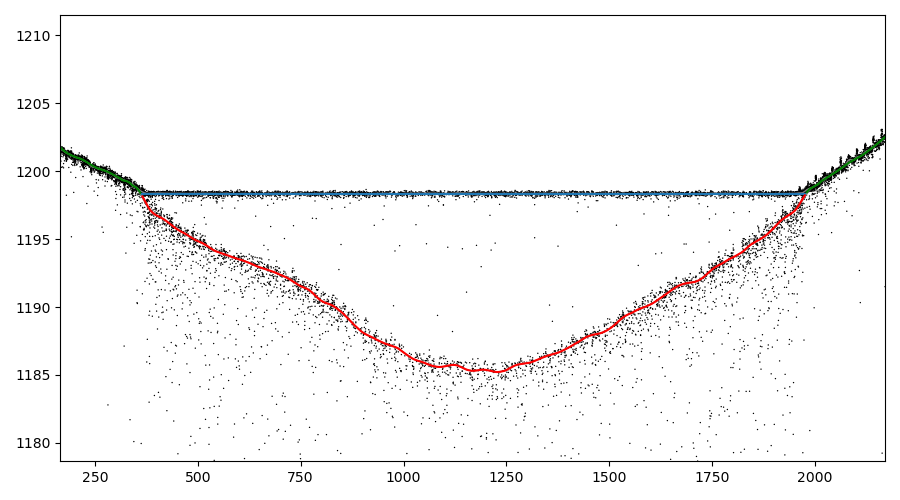

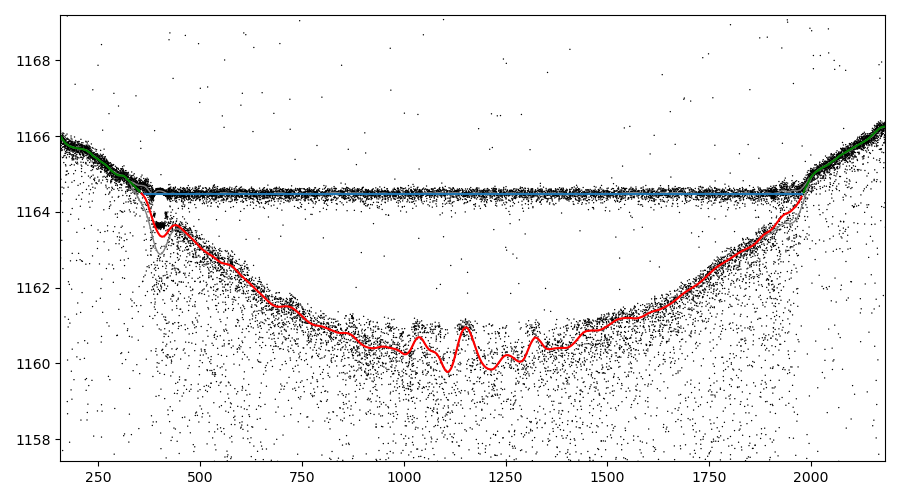

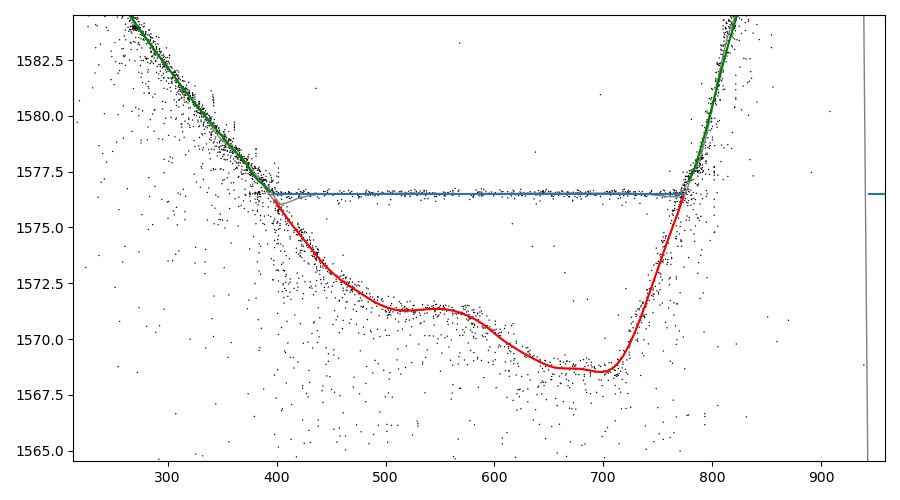

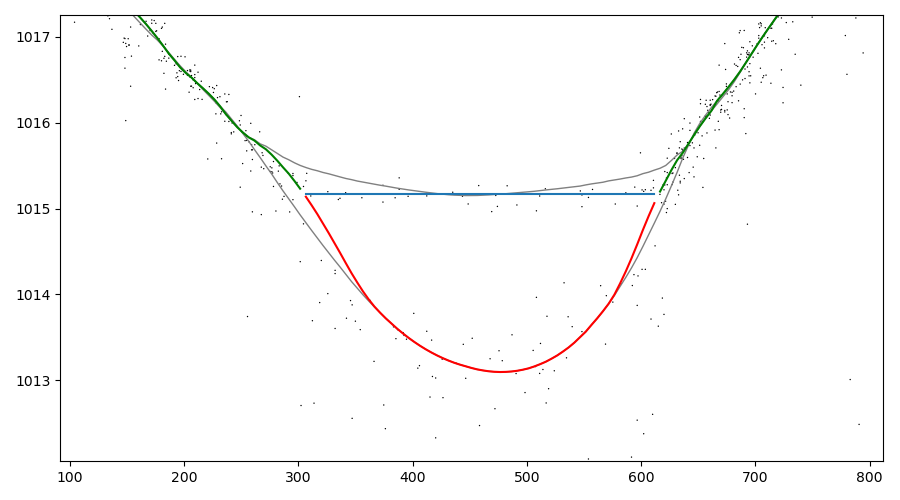

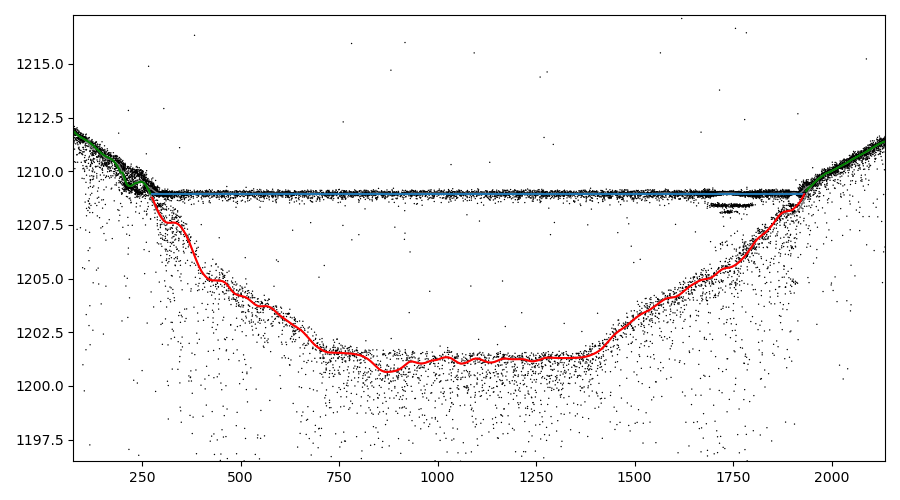

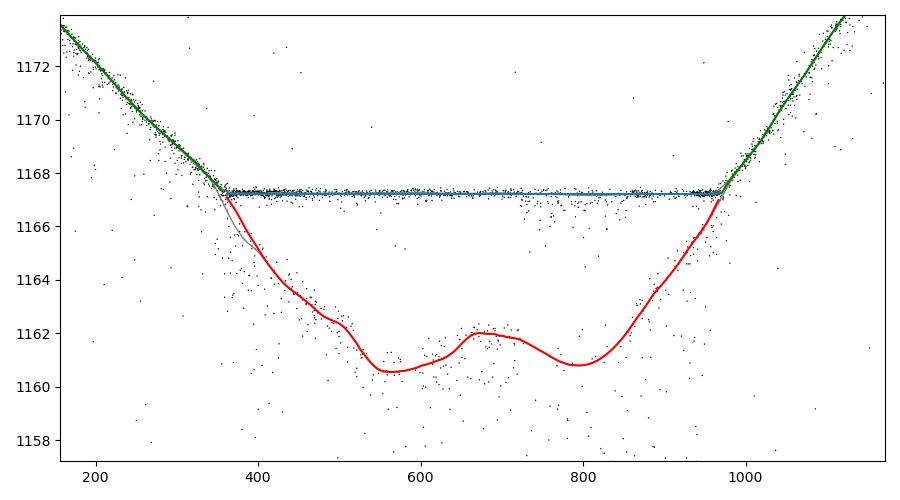

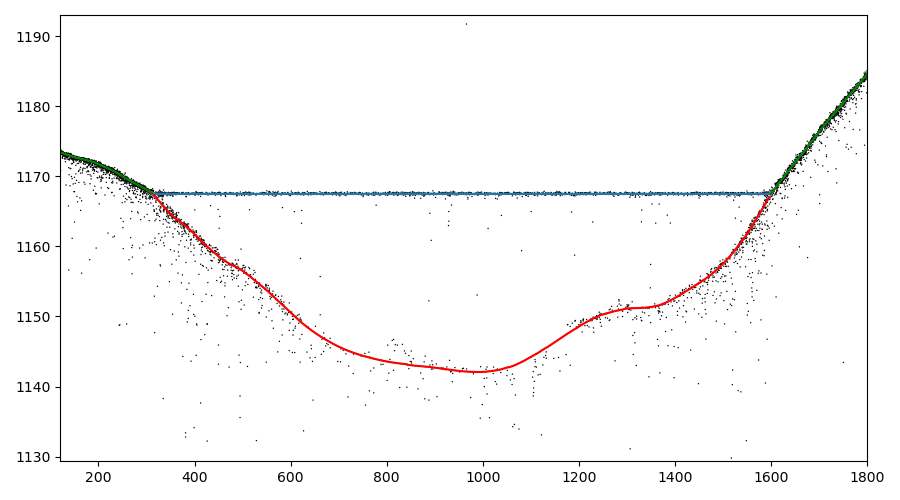

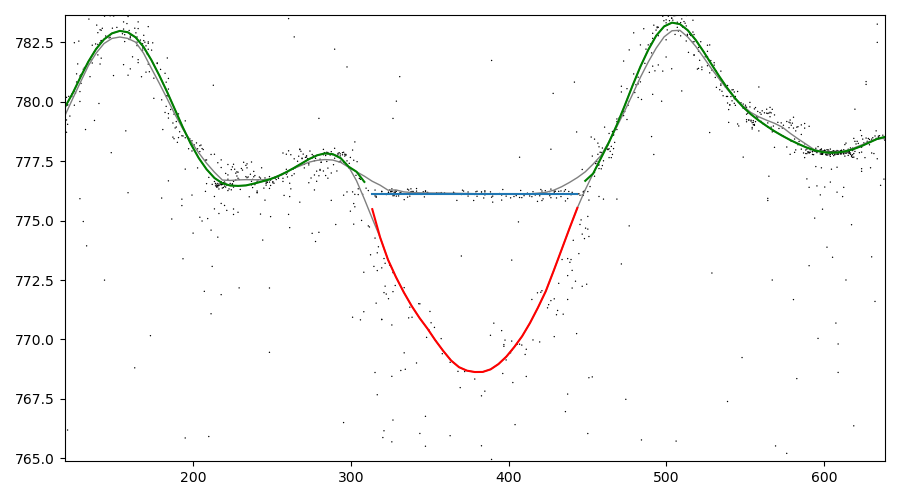

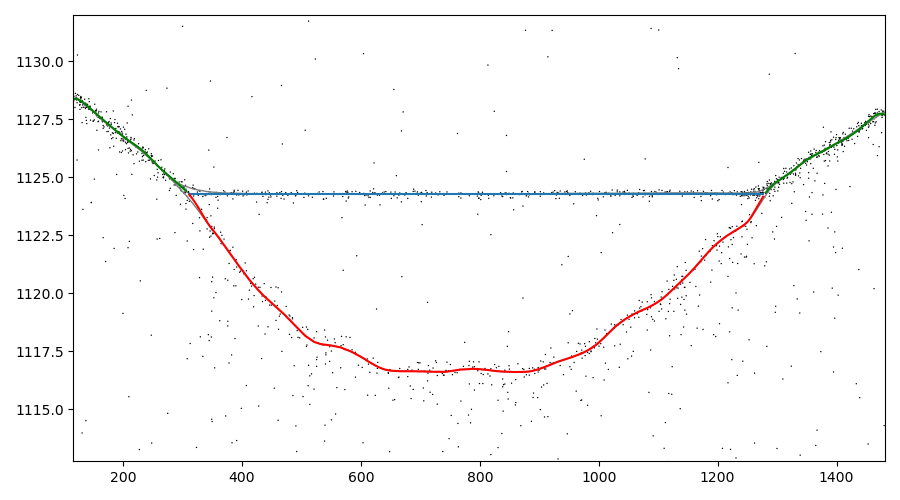

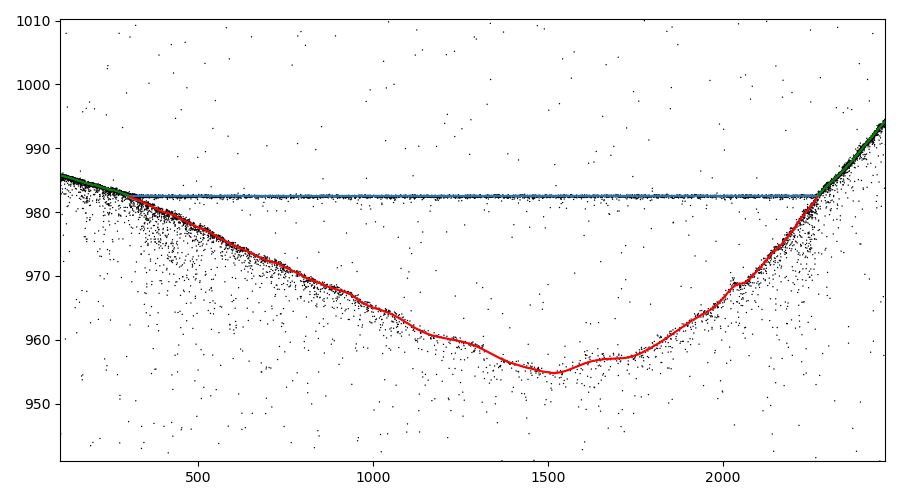

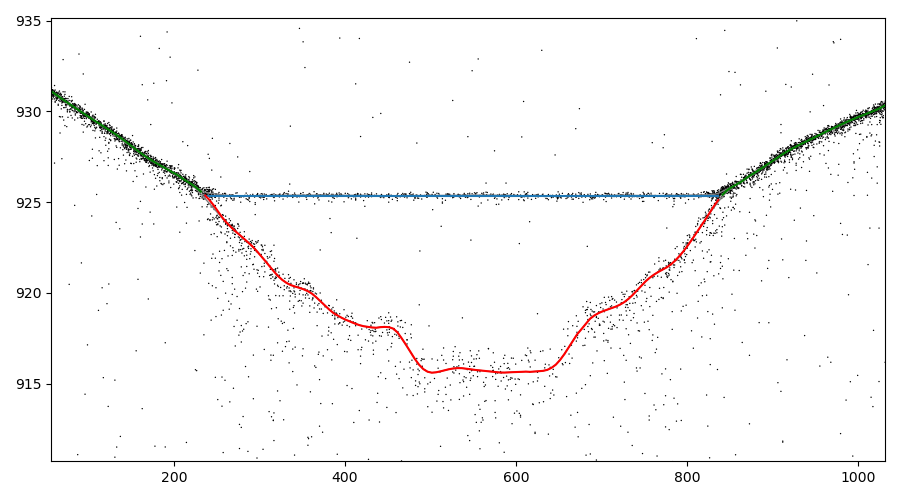

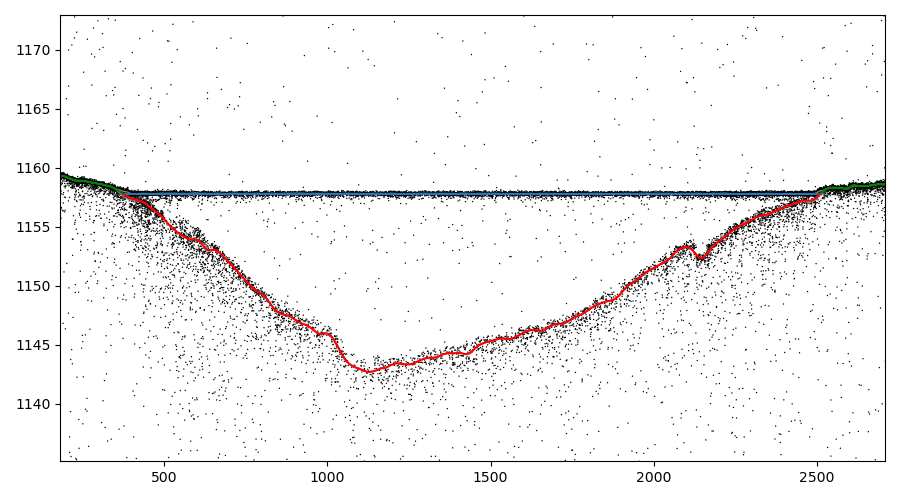

In [16]:
plt.close('all')
ref_idx = 1.336
for i, fn in enumerate(np.array(filelist)[np.array([1,2,3,4,5,6,8,9,10,11,12,13])]):

    print(i)

    lk = dictobj(read_melt_lake_h5(fn))
    
    df = lk.photon_data.copy()
    dfd = lk.depth_data.copy().reset_index(drop=True)
    fix_fringes(lk, h_range=1.0, verbose=True)
    dfd_fix = lk.depth_data.copy().reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize = [9,5])
    
    ax.scatter(df.xatc, df.h, s=1, color='k', edgecolors='none')
    ax.plot(dfd.xatc, dfd.h_fit_surf, color='gray', lw=1)
    ax.plot(dfd.xatc, dfd.h_fit_bed, color='gray', lw=1)
    
    xfix = dfd_fix.xatc.copy()
    xfix[dfd_fix.h_fit_bed < lk.surface_elevation] = np.nan
    ax.plot(xfix, dfd_fix.h_fit_bed, color='g')
    xfix = dfd_fix.xatc.copy()
    xfix[dfd_fix.h_fit_bed > lk.surface_elevation] = np.nan
    ax.plot(xfix, dfd_fix.h_fit_surf*0 + lk.surface_elevation, color='C0')
    ax.plot(xfix, dfd_fix.h_fit_bed, color='r')
    
    ax.set_xlim((dfd.xatc.min(), dfd.xatc.max()))
    ax.set_ylim((lk.surface_elevation - 1.5*lk.max_depth*ref_idx, lk.surface_elevation + 1.0*lk.max_depth*ref_idx))
    
    fig.tight_layout()
    # plt.close(fig)
    # display(fig)

In [43]:
isfringe.index()

0      False
1      False
2      False
3      False
4      False
       ...  
401    False
402    False
403    False
404    False
405    False
Length: 406, dtype: bool

## create all the quicklook plots

In [ ]:
##### FOR ALL data
replace_existing = False # whether to make a new plot if a plot with the specified name already exists
show_plots = False

#________________________________________________________
# temp for testing
# filelist = filelist[:3]
#________________________________________________________

listlength = len(filelist)
print('\nThere are %d lake files to process...' % listlength)

import time
from IPython.display import clear_output
def time_string(secs):
    m, s = divmod(secs, 60)
    h, m = divmod(m, 60)
    d, h = divmod(h, 24)
    return '%d days, %d hrs, %d mins, %d secs' % (d, h, m, s)
plt.close('all')

tstart = time.time()
idone = 0
for i, fn in enumerate(filelist):

    dir_context = fn[:fn.rfind('/')+1].replace('/detection_out_data/', '/detection_context/')
    if not os.path.exists(dir_context):
        os.makedirs(dir_context)
    fn_context = fn.replace('/detection_out_data/', '/detection_context/').replace('.h5', '_context.jpg')
    
    dir_imagery = fn[:fn.rfind('/')+1].replace('/detection_out_data/', '/detection_imagery/')
    if not os.path.exists(dir_imagery):
        os.makedirs(dir_imagery)
    fn_imagery = fn.replace('/detection_out_data/', '/detection_imagery/').replace('.h5', '_imagery.tif')    

    if (not os.path.isfile(fn_context)) or replace_existing:
        
        tnow = time.time()
        selapsed = tnow - tstart
        elapsed = time_string(selapsed)
        if idone > 0:
            sremaining = (listlength-i) / idone * selapsed
            remaining = time_string(sremaining)
        else:
            remaining = 'undefined'
        ns = int(np.round((i+1)/listlength*100))
        print('\n[' + '#'*ns + '.'*(100-ns) + ']\n')
        print('%i / %i lakes processed (%i this run)' % (i+1, listlength, idone+1))
        print('%s elapsed' % elapsed)
        print('%s remaining' % remaining)
        print('current file: %s' % fn_context.split('/')[-1])
        if (i < (listlength-1)) and (not show_plots):
            clear_output(wait=True)

        idone += 1

        settings = {
            're_download': True,     # True
            'img_aspect': 1.0,        # 1.0
            'days_buffer': 5,         # 5
            'max_cloud_scene': 20,    # 20               (make this smaller, more like 30?)
            'max_cloud_mask': 40,     # 50               (make this smaller, more like 30?)
            'n_imgs_mosaic': 5,       # 7                (put to one for checking code)
            'mosaic_method': 'mean',  # mean             (alternatively "median" or "mosaic")
            'scale_out': 10,          # 10
            'gamma_value': 1.0,       # 1.0
            'xlm': [None, None],      # [None, None]     (keep at None unless adjusting for a particular plot)
            'ylm': [None, None],      # [None, None]     (keep at None unless adjusting for a particular plot)
            'return_fig': False       # False
        }
    
        fig = plt.figure(figsize=[10,4.35])
        gs = fig.add_gridspec(ncols=9, nrows=1)
        
        axs = []
        axs.append(fig.add_subplot(gs[0, :4])) 
        axs.append(fig.add_subplot(gs[0, 4:]))

        try:
            lk = dictobj(read_melt_lake_h5(fn))
            
            plot_IS2_imagery(fn=fn, imagery_filename=fn_imagery, **settings, axes=axs)
            fig.tight_layout(pad=0.3, h_pad=0.3, w_pad=0.4)
        except:
            axs[0].text(0.5, 0.5, 'plotting error', fontsize=12, ha='center', va='center', transform=axs[0].transAxes)
            traceback.print_exc()
    
        plt.close(fig)
        fig.savefig(fn_context, dpi=300)

        if show_plots:
            print('\nFigure created:')
            display(fig)



[#...................................................................................................]

133 / 15098 lakes processed (133 this run)
0 days, 0 hrs, 13 mins, 15 secs elapsed
1 days, 1 hrs, 2 mins, 53 secs remaining
current file: lake_097619_GrIS_2020_simplified_GRE_2200_NW_ATL03_20200802111625_05820803_006_01_gt2l_0014_context.jpg
